# Loosely Coupled Sensor Fusion.
## IMU + GNSS for quadrotor dynamic

In [1]:
import numpy as np
import scipy.io as scyIO 
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define constants 
Ts = 0.01
gravity = 9.81

dt = Ts

In [240]:
def q2dcm(q,_raw = False):
    
   #Function for transformation from quaternions to directional cosine matrix
   #Farell pp.41
   #Edit: MAtteo

    qx = float(q[0])
    qy = float(q[1])
    qz = float(q[2])
    qw = float(q[3])
    
    if _raw:
        DCM = np.array([[1 - 2 * qy**2 - 2*qz**2,2*qx*qy - 2*qz*qw,2*qx*qz + 2*qy*qw],
                        [2*qx*qy + 2*qz*qw,1 - 2*qx**2 - 2*qz**2,2*qy*qz - 2*qx*qw],
                        [2*qx*qz - 2*qy*qw,2*qy*qz + 2*qx*qw,1 - 2*qx**2 - 2*qy**2]
                        ])# ===> OK
        
    else:

        p = np.array([qx**2,qy**2,qz**2,qw**2,0,0])
        p[4] = p[1] + p[2]
        
        if abs(p[0]+p[3]+p[4]) <= 1e12:
            p[5]=2.0/(p[0] + p[3]+p[4]) 
        else:
            p[5]=0
    
        DCM =np.zeros((3,3))
        
        DCM[0,0] = 1 - p[5] * p[4]
        DCM[1,1] = 1 - p[5] * (p[0]+p[2])
        DCM[2,2] = 1 - p[5] * (p[0]+p[1])
        
        p[0] = p[5] * q[0]; 
        p[1] = p[5] * q[1];
        p[4] = p[5] * q[2] * q[3];
        p[5] = p[0] * q[1];
        
        
        DCM[0,1] = p[5] - p[4];
        DCM[1,0] = p[5] + p[4];
        
        p[4] = p[1] * q[3];
        p[5] = p[0] * q[2];

        DCM[0,2] = p[5] + p[4];
        DCM[2,0] = p[5] - p[4];
        
        p[4] = p[0]* q[3];
        p[5] = p[1]* q[2];

        DCM[1,2] = p[5] - p[4];
        DCM[2,1] = p[5] + p[4];
        
    DCM = DCM.reshape(3,3)# ==> OK 
    
    #% orthogonalization (single-step): A0(t)*3/2- A0(t)*A0^T(t)*A0(t)/2
    DCM = 3./2.* DCM - np.dot(DCM,np.dot(DCM.T, 1./2. * DCM ))
    
    
    return DCM



In [296]:
def dcm2q(R):
    #Adapted for singularity avoidance: https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
    
    q = np.zeros((4,1));
    if(1 + float(R[0,0]) + float(R[1,1]) + float(R[2,2]) > 0 ):

        q[3]=0.5 * np.sqrt(1 + R[0,0] + R[1,1] + R[2,2]);
            #Euler's angle

        q[0] = (R[2,1]-R[1,2])/(4*q[3]);
            #Euler's axis_x

        q[1] = (R[0,2]-R[2,0])/(4*q[3]);
            #Euler's axis_y

        q[2]=  (R[1,0]-R[0,1])/(4*q[3]);
            #Euler's axis_z

       
        
    else:
        print("switching A-repr")
        m00 = R[0,0]
        m11 = R[1,1]
        m22 = R[2,2]
        
        m10 = R[1,0]
        m12 = R[1,2]
        m02 = R[0,2]
       
        m01 = R[0,1]
        m21 = R[2,1]
        m20 = R[2,0]
        
        
        
        tr = m00 + m11 + m22
        
        if ((m00 > m11) and (m00 > m22)):
            print(" using first<==")
            S = np.sqrt(1.0 + m00 - m11 - m22) * 2; 
            assert(abs(S)>0)
            qw = (m21 - m12) / S;
            qx = 0.25 * S;
            qy = (m01 + m10) / S; 
            qz = (m02 + m20) / S; 
            
            q = np.array([qw,qz,qy,qx]).reshape((4,1))
            
        elif (m11 > m22):
            print(" using second<==")
            S = np.sqrt(1.0 + m11 - m00 - m22) * 2; 
            assert(abs(S)>0)
            qw = (m02 - m20) / S;
            qx = (m01 + m10) / S; 
            qy = 0.25 * S;
            qz = (m12 + m21) / S; 
            
            q = np.array([qz,qw,qx,qy]).reshape((4,1))
                
        else: 
            print(" using third<==")
            S = np.sqrt(1.0 + m22 - m00 - m11) * 2; 
            assert(abs(S)>0)
            qw = (m10 - m01) / S;
            qx = (m02 + m20) / S;
            qy = (m12 + m21) / S;
            qz = 0.25 * S;
            q = np.array([-qx,-qy,qz,qw]).reshape((4,1))
            #q = np.array([qy,qx,qw,qz]).reshape((4,1))
            
       
        #print(R)
        #print(q)
    
        
    
    
    return q /np.linalg.norm(q)

In [297]:
q_test = np.array([0, 0, 0.7071,0.7071]).reshape(4,1)# rotation of 90° about z
v_test = np.array([1,0,0]).reshape(3,1);

DCM_nraw = q2dcm(q_test)
DCM_raw = q2dcm(q_test, True)

#ORTHOGONALITY TEST:
print('===================================================')
print('---------------------------------------------- NRAW')
print(np.dot(DCM_nraw,DCM_nraw.T))
print('----------------------------------------------  RAW')
print(np.dot(DCM_raw,DCM_raw.T) )
print('===================================================')
#BACK TRASFORMATION TEST
dcm2q(DCM_nraw)
print('------------------------------------------------RAW')
print(q_test," \n ",dcm2q(DCM_raw))
print(q_test - dcm2q(DCM_raw))
print('---------------------------------------------- NRAW')
print(q_test," \n ",dcm2q(DCM_nraw))
print(q_test - dcm2q(DCM_nraw))
print('===================================================')



---------------------------------------------- NRAW
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
----------------------------------------------  RAW
[[9.99999999e-01 1.62501299e-21 0.00000000e+00]
 [1.62501299e-21 9.99999999e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
------------------------------------------------RAW
[[0.    ]
 [0.    ]
 [0.7071]
 [0.7071]]  
  [[0.        ]
 [0.        ]
 [0.7071    ]
 [0.70711356]]
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.25152016e-10]
 [-1.35626332e-05]]
---------------------------------------------- NRAW
[[0.    ]
 [0.    ]
 [0.7071]
 [0.7071]]  
  [[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]]
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.78118655e-06]
 [-6.78118655e-06]]


In [298]:
#Test for a rotation about z of 90°
dcm_test = q2dcm(q_test)
print(dcm_test)
v_test_rot = np.dot(dcm_test , v_test)

print(v_test_rot,v_test_rot.shape, np.linalg.norm(v_test_rot))

[[ 1.11022302e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.11022302e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[1.11022302e-16]
 [1.00000000e+00]
 [0.00000000e+00]] (3, 1) 1.0


____________________________________________________________________
## Governing Equations

$state  \rightarrow \mathbf{x} $
 
 $\mathbf{x} = \{p_x, p_y, p_z,v_x, v_y, v_z, q_x, q_y, q_z, q_w\}^T $  , $ \mathbf{x} \in \mathbb{R}^{10}$


$ measurement(IMU) \rightarrow \mathbf{\tilde{u}}$  

$ \mathbf{\tilde{u}}= \{a_x, a_y, a_z, \omega_x,\omega_y,\omega_z\}^T \triangleq \{ \mathbf{s}, \boldsymbol{\omega}\} $, $ \mathbf{\tilde{u}} \in\mathbb{R}^{6} $    </br>

*accelerometers are meant to detect external accelerations (and rotations) in the Body refence frame ($\mathcal{B}$).<br> Obviously GPS will provide any position information in an absolute reference frame:* ($\mathcal{N}$)

*where:*
$ \mathbf{v} \lvert_{\mathcal{N}} =  \mathbf{R}^n_b (\mathbf{q})   \mathbf{v} \lvert_{\mathcal{B}}$


1. $\mathbf{p_k} = \mathbf{p_{k-1}} + T_s \mathbf{v_{k-1}} + (T_s^2) [ \mathbf{R_b^n}(\mathbf{q_{k-1}})\mathbf{s_{k-1}} - \mathbf{g}]$ *(position in $\mathcal{N}$ reference frame)*

<br>

2. $\mathbf{v_k} = \mathbf{v_{k-1}} + (T_s) [ \mathbf{R_b^n}(\mathbf{q_{k-1}})\mathbf{s_{k-1}} - \mathbf{g} ] $ *(velocity in $\mathcal{N}$ reference frame)*

<br>

3. $\mathbf{q_k} =  [ cos(\frac{1}{2} \frac{T_s}{\lvert\lvert \boldsymbol{\omega} \lvert\lvert^2}) \mathbf{I_4} +sin(\frac{1}{2} \frac{T_s}{\lvert\lvert \boldsymbol{\omega} \lvert\lvert^2}) \boldsymbol{\Omega_k}] \mathbf{q_{k-1}} $ 
   
   (*quaternion's kinematic. **NB**: this quaternions are the ones for rotation: $\mathcal{B} \rightarrow \mathcal{N}$*)

*where* $\boldsymbol{\Omega_k} = \left[\begin{array} {c,c,c,c}
                                         0 ,\omega_z , -\omega_y , \omega_x \\
                                        -\omega_z , 0 , \omega_x , \omega_y \\
                                        \omega_y , -\omega_x , 0 , \omega_z \\
                                        -\omega_x , -\omega_y , -\omega_z ,0 
                                        \end{array} \right]$
        
 *and* $\mathbf{R_b^n}(\mathbf{q}) = \left[\begin{array} {c,c,c}
                                           q_w^{2}+ q_x^2− q_y^2 − q_z^2, ... ,.. \\
                                           ..., ... , ... \\
                                           ..., ...., ...
                                             \end{array} \right]$
                                             
 $\small{refer \quad to : \text{http://www.tu-berlin.de/fileadmin/fg169/miscellaneous/Quaternions.pdf}}$

**NOTE:** *implemented algortithm avoid singularity*: $q_x^{2} + q_w^{2} + q_x-q_w = 0$

##### Key-Point: 
*IMU sensor model is modeled as the sum of a bias error measurement following a "random-walk-dynamic".*

$ \mathbf{\tilde{u}} = \mathbf{u} - \mathbf{\delta u}_k + \mathbf{w}^{(1)}$
<br> *where*<br>
     $ \mathbf{\delta u}_k = \mathbf{\delta u}_{k-1} + \mathbf{w}^{(2)} $
     
     
  *Moreover $\mathbf{w}^{(1)}$ and $\mathbf{w}^{(2)}$ are uncorrelated with covariance matrices: $\mathbf{Q^{(1)}}, \mathbf{Q^{(2)}}$respectively*
____________________________________________________________________

In [299]:
def gravity(_lambda =59 , h=0):
    
    _lambda=np.pi/180*_lambda;

    gamma=9.780327*(1+0.0053024*np.sin(_lambda)**2-0.0000058*np.sin(2*_lambda)**2);

    g=gamma-((3.0877e-6)-(0.004e-6)*np.sin(_lambda)**2)*h+(0.072e-12)*h**2;

   
    #
    g_0 = np.array([0,0,-g]).reshape(3,1)
    return g_0
print(gravity())
def nav_equations(x,u,dt):
    ### traslation
    pv = x[:6]
    q = x[6:]
    A = np.eye(6)
    
    A[0,3] = dt
    A[1,4] = dt
    A[2,5] = dt #here implements simple integrator: x[t] = x[t-1] + vx * dt
    
    f_t = np.dot(q2dcm(q),u[:3])
    acc_t = f_t - gravity()
    
    B = np.concatenate((np.eye(3,3) * (dt**2)/2, np.eye(3,3) * dt))
    
    x_pv = np.dot(A,x[:6])+ np.dot(B,acc_t)
    
    ### rotation
    w_t = u[3:]
    P = w_t[0] * dt
    Q = w_t[1] * dt
    R = w_t[2] * dt
    
    
    OMEGA = np.array([[0, R, -Q, P],
                      [-R, 0, P, Q],
                      [Q, -P, 0, R],
                      [-P, -Q, -R, 0]])
    
    V = np.linalg.norm(w_t) * dt
    
    x_rot = np.dot(np.cos(V/2) * np.eye(4) + 2/V * np.sin(V/2) * OMEGA ,x[6:])
    
    x = np.zeros((10,1))
    x[:6] = x_pv
    x[6:] = x_rot
    
    return x

### Test
x_test = np.array([1,1,0,0.1,0.1,0,q_test[0],q_test[1],q_test[2],q_test[3]]).reshape(10,1)
u_test = np.array([1,0,0,1,2,0]).reshape(6,1)
x_test_t = nav_equations(x_test,u_test,dt)
print(x_test_t)
print(x_test_t.shape)

[[ 0.        ]
 [ 0.        ]
 [-9.81838559]]
[[ 1.00100000e+00]
 [ 1.00105000e+00]
 [ 4.90919280e-04]
 [ 1.00000000e-01]
 [ 1.10000000e-01]
 [ 9.81838559e-02]
 [-7.07085269e-03]
 [ 2.12125581e-02]
 [ 7.07055807e-01]
 [ 7.07055807e-01]]
(10, 1)


____________________________________________________________________

## State-Space Equations

*Instead of filetering the proper system's dynamic (which can always be filtered separately), the current implementation apply the filter to errors dynamic.*

$ \mathbf{z}_k = \{\mathbf{\delta x}, \mathbf{\delta u}\} \in \mathbb{R}^{15} $
    $ \Rightarrow$
$ \mathbf{z} =\{\mathbf{\delta p_{3 \times 1}},
                \mathbf{\delta v_{3 \times 1}},
                \boldsymbol{\delta \epsilon_{3 \times 1}} \lvert
                \mathbf{\delta w^{(1)}_{3 \times 1}}
                \mathbf{\delta w^{(2)}_{3 \times 1}}\}  $
                
*as*
$\dot{\mathbf{z}_k} = F(\mathbf{z}_{k-1}) \mathbf{z}_{k-1} + G(\mathbf{z}_{k-1}) \mathbf{w}_{k}$ <br>


***where***: <br>
*1. the minimal attiture representation is kept, replacing quaternions with $\epsilon$, wich actually is the **small-rotations** difference* 
 
$\boldsymbol{\delta \epsilon } \quad  s.t. \quad \exists \quad \Gamma (\mathbf {q}, \boldsymbol{\epsilon}) \triangleq \{ \mathbf{q} \in SO^3 \quad \lvert \quad \mathbf{R_b^n}(\mathbf{q}) = [\mathbf{I_3} - [\boldsymbol{\epsilon}]_{\times} ] \mathbf{R_b^n}(\mathbf{\hat{q}})   \} $

$[\mathbf{\epsilon}]_{\times}=\left[\begin{array} {c,c,c}
                                           0, \epsilon_y , -\epsilon_z \\
                                           \epsilon_z, 0 , \epsilon_x \\
                                           \epsilon_x, -\epsilon_y, 0
                                             \end{array} \right]$
                                             
                                             
*As the filter computes small (infinitestimal) rotations errors the corrections on quaternions must be performed as follow:*

$KF\quad \rightarrow \quad \boldsymbol{\delta \epsilon} \quad \rightarrow  \quad
\mathbf{R_b^n}(\mathbf{\hat{q}}) = (\mathbf{I}_3 - [\mathbf{\epsilon}]_{\times} )\mathbf{R_b^n}(\mathbf{q}) \quad  \rightarrow \quad  \mathbf{\hat{q}} \quad \tiny{\text{ ( final step to be performed with DCM2q) }} $


                                              

*2. estimation error:* <br> 

$ \mathbf{\delta x} = \mathbf{\hat{x}} - \mathbf{x} $ 
( * estimated - true *),
<!-- $\mathbf{\delta u} = \mathbf{\hat{u}} - \mathbf{u} $-->




<img src="./Loosely_coupled_Kf.png"/>


**NOTE-1**: *the filter is going to correct the error relying on GPS measurement, therefore the covariance of observation noise ($\mathbf{R}$) is equal to the GNSS measurement's uncertainty* 

**NOTE-2**: *the step 'update attitude' is performed through $\Gamma$*

________________________________________________________________________


In [300]:
def state_space_model(x,u,Ts):
    q = x[6:]
    q /= np.linalg.norm(q)
    Rb2n = q2dcm(q)
    
            
    # rotate accelerometer(s) measurement in absolute frame
    f_n = np.dot(Rb2n,u[:3])
    # Submatrix implementing: [Rb2n * fn]X ( skew matrix)
    Sn = np.array([[0 ,float(-f_n[2]), float(f_n[1])],
                    [float(f_n[2]), 0, float(-f_n[0])],
                    [float(-f_n[1]), float(f_n[0]), 0]]).reshape(3,3)
    
    
    O = np.zeros((3,3))
    I = np.eye(3)
    
    #F = np.zeros((15,15))
    Rb2n = Rb2n.reshape((3,3))
    Fc = np.block([[O, I ,  O,     O,    O],
                   [O, O,  Sn,  Rb2n,    O],
                   [O, O,  O,      O,-Rb2n],
                   [O, O ,  O,     O,    O],
                   [O, O ,  O,     O,    O]])#size 15 X 15
    
    F = np.eye(15,15) + Ts * Fc
    
    G= Ts * np.block([[ O  ,  O , O ,O],
                    [ Rb2n ,O , O ,O],
                    [ O, -Rb2n, O ,O],
                    [ O,   O  , I ,O],
                    [ O,   O  , O ,I ]])#size 15 X 12
    
    
    
    return F,G
    

F_test, G_test = state_space_model(x_test,u_test,Ts)

dz_test = np.ones((15,1))
w_test = np.ones((12,1))
dz_test_t = np.dot(F_test,dz_test) + np.dot(G_test,w_test)
print(dz_test_t, dz_test.shape)

[[1.01]
 [1.01]
 [1.01]
 [0.99]
 [1.02]
 [1.01]
 [1.02]
 [0.98]
 [0.98]
 [1.01]
 [1.01]
 [1.01]
 [1.01]
 [1.01]
 [1.01]] (15, 1)


In [301]:
def Gamma(q,epsilon):
    R = q2dcm(q)
    
    # Construct skew symetric matrix, for small(infinitesimal) rotations
    OMEGA_sr = np.array([[0, -epsilon[2], epsilon[1] ],
                         [epsilon[2], 0, -epsilon[0] ],
                         [-epsilon[1], epsilon[0], 0]]).reshape(3,3);

    #% Correct the DCM matrix
   
    R = np.dot((np.eye(3) - OMEGA_sr),R);
    
    q_corrected = dcm2q(R)
    
    q_corrected /= np.linalg.norm(q_corrected)
    
    return q_corrected 


print('===================================================')
print(dcm2q(q2dcm(q_test)))
eps = np.array([[0.01],[0.01],[0.01]])
print(Gamma(q_test,eps))


print('===================================================')    
    
    
    

[[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]]
[[-7.03562716e-03]
 [-6.10243380e-19]
 [ 7.03562716e-01]
 [ 7.10598343e-01]]


## Sensors' data 
*1. Structure sensor(s) data*<br>
*2. plot time-series* <br>
*2. Fit Covariance*

In [302]:
# Load the .mat file:
files = os.listdir(os.getcwd()+'/../GPSaidedIMU')
in_data = [os.getcwd()+'/../GPSaidedIMU/' + f   for f in files  if ".csv" in f ]
mats = [os.getcwd()+'/../GPSaidedIMU/' + f   for f in files  if ".mat" in f ]

mats
in_data


['/Users/teobaiguera/Documents/Study/Kalman_Cpp/python/../GPSaidedIMU/ACC_data.csv',
 '/Users/teobaiguera/Documents/Study/Kalman_Cpp/python/../GPSaidedIMU/GNSS_data.csv',
 '/Users/teobaiguera/Documents/Study/Kalman_Cpp/python/../GPSaidedIMU/GYRO_data.csv']

In [303]:
class SensorData:
    delimiter = ","

    def __init__(self,datafile_,name):
        self.__data = np.loadtxt(datafile_, delimiter = SensorData.delimiter)
        self.__time = self.__data[:,0]
        self.__readings = self.__data[:,1:]
        
        self.name = name
        self.tmax = self.__time[-1];
        
        self.Ts = 0
        self.Qcov = None
        self.last_idx = 0
        
        for i in range(len(self.__time[1:])):
            dt = self.__time[i] - self.__time[i-1]
            if dt > self.Ts:
                self.Ts = dt
            
    def __getitem__(self,idx):
        try:
            assert(idx < len(self.__time))
        except IndexError:
            
            print("OUT OF RANGE")
            return None , None
        
        return self.__readings[idx]
    
    
    def t(self,idx):
        
        try:
            assert(idx < len(self.__time))
        except IndexError:
            print(" TIME OUT OF RANGE")
            return None , None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
        
        return float(self.__time[idx])

    def at(self, t, check_only = False):
        # Enable Check for GNSS availability
        if t < self.__time[-1]  and  t > self.__time[self.last_idx]:
            
            time_idx = np.array([ idx for idx,tt in enumerate(self.__time) if tt >= t])
            
            if len(time_idx) > 0:
                
                if not check_only:
                    self.last_idx = time_idx[0]
                
                return self.__readings[time_idx[0]].reshape((3,1))
            
            else:
                print("first aq")
                return None
        
        else:
            return None
        
        
    def plot(self):
        names = [self.name +'_1', self.name +'_2', self.name +'_3']
        plt.plot(self.__time,self.__readings)
        plt.legend(names)
        plt.xlabel('time(s)')
        plt.ylabel('readings')
        plt.show()
        
    def reset_index(self):
        self.last_idx =0
        
        
    def gettime(self):
        return self.__time
    
    def getdata(self):
        return self.__readings
    
    def sigma_fit(self):
        print(np.cov(self.__readings))
        
        

[-1.01938165 -0.97581071 -9.89077144]
0.0100000000000193
[[-0.72095549]
 [-0.48933222]
 [-9.51488255]]


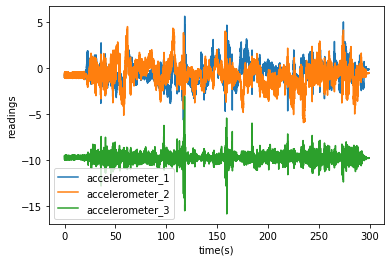

In [304]:
accelerometer = SensorData(os.getcwd()+'/../GPSaidedIMU/ACC_data.csv',"accelerometer")
print(accelerometer[31])
print(accelerometer.t(1))
print(accelerometer.at(1))

accelerometer.plot()


OK sensor samples at same time => as they acquire at same time!!


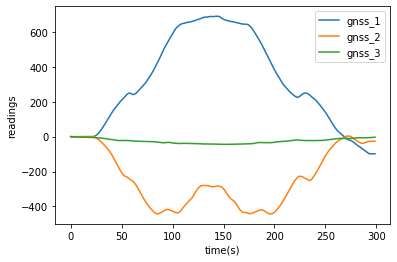

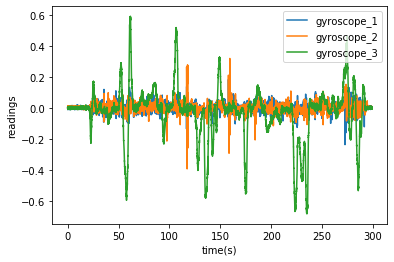

In [305]:
gyroscope = SensorData(os.getcwd()+'/../GPSaidedIMU/GYRO_data.csv',"gyroscope")
gnss = SensorData(os.getcwd()+'/../GPSaidedIMU/GNSS_data.csv',"gnss")

try:
    assert(gyroscope.Ts == accelerometer.Ts )
    for g,a in zip(gyroscope.gettime() , accelerometer.gettime()):
        assert(g == a)
    print("OK sensor samples at same time => as they acquire at same time!!")
except:
    print("no same Ts for accelerometer")
    
gnss[3]
gnss.plot()
gyroscope.plot()

### Kalman fliter 
#### Filter is on  sensor(s) error measurement error.


In [306]:
class KalmanFilterLooselyIMUGNNS:
    def __init__(self,Q1,Q2,z0,
                 gamma_fcn = Gamma,
                 p_uncertainty = 10 , v_uncertainty = 5, 
                 rpy_uncertainty = [np.pi/180.0 * 1.,np.pi/180.0 * 1., np.pi/180.0 * 20.],
                 acc_biases = 0.02, gyro_biases = 0.05*np.pi/180,
                 gnss_uncertainty = np.sqrt(3),
                 delta_u_h_init = np.zeros((6,1))):
    
        # Gamma function, attitude correction starting from error propagation.
        self.Gamma = gamma_fcn
        # Measurement (output) matrix, a.k.a filter's observation matrix ( from GNSS)
            #=>  H s.t. y_k - y_GNSS_k =  p_gps - p_estimate = delta_y = H * z_k + ek
        O = np.zeros((3,3))
        self.H = np.hstack([np.eye(3),O,O,O,O])
        assert(self.H.shape == (3,15))
        
        # measurement covariance:
        self.R = (gnss_uncertainty**2) * np.eye(3)
        
        # Process covariance:
        self.Q1 = Q1
        self.Q2 = Q2
        
        O1 = np.zeros((self.Q1.shape[0],self.Q2.shape[1] ))
        O2 = np.zeros((self.Q2.shape[0],self.Q1.shape[1] ))
                      
        self.Q = np.array([[self.Q1,O1],
                           [O2,self.Q2]]).reshape((self.Q1.shape[0]+self.Q2.shape[0], 
                                              self.Q1.shape[1]+ self.Q2.shape[1] ))
        
        #Filter state:
        self.z = z0
        
        
        #Filter state-covariance: 
            # !! small angles approximation
            # !! rpy uncertainty set equal to all quaternions
            
        p = np.vstack([(p_uncertainty**2) * np.ones((3,1)), 
                       (v_uncertainty**2) * np.ones((3,1)),
                       (np.array(rpy_uncertainty)**2).reshape((3,1)),
                       (acc_biases**2) * np.ones((3,1)),
                       (gyro_biases**2) * np.ones((3,1))])
    
        assert(p.shape == (15,1))
        
        self.P = np.eye(15) * p 
        assert(self.P.shape == (15,15))
        
        
        #Init gain to null
        self.K = None
        #Init delta_u_h to null
        self.delta_u_h = delta_u_h_init
        
 
    #As F,G depend on the system state x => Are function of error. 
    def predict(self,F,G):
        #% P=F*P*F'+G*blkdiag(Q1,Q2)*G';
        self.P = np.dot(F , np.dot(self.P , F.T) ) + np.dot(G , np.dot(self.Q,G.T))

    def compute_gain(self,F,G):
        #%K=(P*H')/(H*P*H'+R);
        A = np.dot(self.P,self.H.T)
        
        B = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        B_inv = np.linalg.inv(B)
        
        #Update gain
        self.K = np.dot(A,B_inv)
    
    def update(self,y,x):
        #% z=[zeros(9,1); delta_u_h]+K*(y-H(:,1:6)*x_h(1:6));
        #% P=(eye(15)-K*H)*P;
        
     
        z_ = np.zeros((15,1))
        z_[:9] = np.zeros((9,1))
        z_[9:] = self.delta_u_h.reshape((6,1))
        
        #?? get 6X6 sub-matrix, is this needed ?? 
        H_ = self.H[:6,:6]#remove attitude observation
        x_ = x[:6]#remove quaternions
        
        self.z = z_ +  np.dot(self.K,(y - np.dot(H_,x_)))
        self.P = np.dot((np.eye(15) - np.dot(self.K,self.H)), self.P)
        
        x_h = np.zeros((10,1))
    
        
        #subtract bias
        x_h[:6] = x[:6] + self.z[:6]
        
        #update attitude.
        x_h[6:10] = self.Gamma(x[6:10],self.z[6:10])
        
        #Get error's update
        self.delta_u_h = self.z[9:]
       
        return x_h
        
        
        

In [307]:
delta_u_h = np.zeros((6,1))
z0 = np.concatenate([np.zeros((9,1)), delta_u_h])

In [323]:
#Q are provided by literature (tutorial)
sigma_acc = 0.05; #% [m/s^2]
sigma_gyro = 0.1*np.pi/180; #% [rad/s]
sigma_acc_bias = 0.0001; #% [m/s^2.5]
sigma_gyro_bias = 0.01*np.pi/180; #% [rad/s^1.5]

q1_acc = (sigma_acc**2) * np.ones((3,1))
q1_gyro = (sigma_gyro**2) * np.ones((3,1))
q1 = np.concatenate((q1_acc, q1_gyro))

#Determine Q1 matrix
Ur = np.zeros((3,3))
Ul= np.ones((3,3))

U = np.hstack((Ul,Ur))
L = np.zeros((3,6))
Id = np.vstack((U,L))

Q_1 = np.zeros((6,6))

#In KTH tutorial Q_1 matrix is not diagonal, can't really understand why
Q_1_diag = True

if Q_1_diag:
    for i in range(Id.shape[0]):
         Q_1[i,i] = q1[i]
    
else:
    for i in range(Id.shape[0]):
        for j in range(Id.shape[1]):
            Q_1[i,j] = Id[i,j] * q1[i]
        
#Determine Q2 matrix
q2_acc = (sigma_acc_bias**2) * np.ones((3,1))
q2_gyro = (sigma_gyro_bias**2) * np.ones((3,1))
q2 = np.concatenate((q2_acc, q2_gyro))
Q_2 = np.zeros((6,6))
for i in range(Id.shape[0]):
    Q_2[i,i] = q2[i]
    
    


#Set error(pos) = {bias + randomWalk} to zero
delta_u_h = np.zeros((6,1))
z0 = np.concatenate((np.zeros((9,1)), delta_u_h))


print(Q_1)
print(Q_2)





[[2.5000000e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 2.5000000e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.5000000e-03 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0461742e-06 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0461742e-06
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  3.0461742e-06]]
[[1.0000000e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.0000000e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e-08 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0461742e-08 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0461742e-08
  0.0000000e+00]
 [0.0000000e+00 0.00

### Program

In [324]:
t_spn_acc = len(accelerometer.gettime())
t_spn_gyro = len(gyroscope.gettime())
t_spn_gnss = len(gnss.gettime())
t_spn = max(t_spn_acc, t_spn_gyro, t_spn_gnss)

In [325]:
# Init: Filter
kf = KalmanFilterLooselyIMUGNNS(Q_1,Q_2,z0)

# Init: current time
t_imu_k_ = 0
df = pd.DataFrame(columns = sorted(['time','x','y','z',
                                    'x_gnss','y_gnss','z_gnss',
                                    'vx','vy','vz',
                                    'q1','q2','q3','q4',
                                    'gnss_corr'])) 


sensors = [accelerometer, gyroscope, gnss]
for s in sensors:
    s.reset_index()

state = ['x','y','z','vx','vy','vz','q1','q2','q3','q4']

# Init:  IMU bias calibration
u = np.concatenate((accelerometer[0],gyroscope[0])).reshape(6,1)

#Init: state & buffer-state
q_h =  np.array([0.021389314953346 ,
                 -0.053921874279912,
                 -0.339870882723627,
                 0.938681368599926]).reshape(4,1)
x_h = np.concatenate(( np.zeros((6,1)), q_h )).reshape(10,1)
x_spn = np.zeros((t_spn,10))




for k in range(1,t_spn)[:11800]:

    # Get (current) sampling time
    assert(gyroscope.t(k) == accelerometer.t(k))
    t_imu_k = accelerometer.t(k)
    Ts = t_imu_k - t_imu_k_
    
    # dictionary for k-th iteration
    d = {'gnss_corr':[ False], 
          'time': [t_imu_k]}
    
  
    #Get IMU sensors reading & shape casting
    u = np.concatenate((accelerometer[k],gyroscope[k])).reshape(6,1)
        
    # Calibrate sensor's bias model
        # according to sensor's model: u_h = u - du 
        # u_h -> calibrated, u -> raw 
        # delta_u_h -> obtained from kalman-filter on s.s. model (last 6 values of z state)
    u_h = u + kf.delta_u_h 
    
    assert(u_h.shape == (6,1))
    
    # predict-step: propagate navigation equation
    assert(x_h.shape == (10,1))
    x_h = nav_equations(x_h, u_h, Ts)

    # Get State-Space model => error(s) dynamic propagation:
    F,G = state_space_model(x_h, u_h,Ts)
    assert(F.shape == (15,15) and G.shape == (15,12))
    
    
    
    #Predict covariance
    kf.predict(F,G)
    
    if gnss.at(t_imu_k,check_only = True) is not None:
        print("--------------------------------------------------------------")
        print("-> -> new GNSS data, updating.. ", t_imu_k,gnss.t(gnss.last_idx))
        kf.compute_gain(F,G)
        y = gnss.at(t_imu_k)
        print(y)
        x_h = kf.update(y,x_h)
        d['gnss_corr'] = [True]
        d['x_gnss'] = y[0]
        d['y_gnss'] = y[1]
        d['z_gnss'] = y[2]
        print("-> -> new GNSS data, updating.. ", t_imu_k,gnss.t(gnss.last_idx))
        print("--------------------------------------------------------------")
        
    else:
        d['x_gnss'] = gnss[gnss.last_idx][0]
        d['y_gnss'] = gnss[gnss.last_idx][1]
        d['z_gnss'] = gnss[gnss.last_idx][2]
        
        
        
        
    #update/append all values:
    for i,k in enumerate(state):
        d[k] = x_h[i]
    
    d={k:v for k,v in sorted( d.items(),key = lambda x: x[0])}
        
    df = pd.concat([df,pd.DataFrame(d,columns=d.keys())])
        
        
    t_imu_k_ = t_imu_k
    
    
    
    
    
     

--------------------------------------------------------------
-> -> new GNSS data, updating..  0.120000000000005 0.110000000000014
[[-0.22280477]
 [ 0.05689071]
 [-0.42300001]]
-> -> new GNSS data, updating..  0.120000000000005 1.11000000000001
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  1.12 1.11000000000001
[[-4.45609500e-01]
 [ 1.16415322e-10]
 [-1.05300002e+00]]
-> -> new GNSS data, updating..  1.12 2.11000000000001
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  2.12 2.11000000000001
[[-5.57011842e-01]
 [ 1.16415322e-10]
 [-1.43800003e+00]]
-> -> new GNSS data, updating..  2.12 3.11000000000001
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  3.12 3.

--------------------------------------------------------------
-> -> new GNSS data, updating..  31.12 31.11
[[ 56.92675889]
 [-41.64330411]
 [-10.67038947]]
-> -> new GNSS data, updating..  31.12 32.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  32.12 32.11
[[ 66.28462335]
 [-48.01484069]
 [-10.39352445]]
-> -> new GNSS data, updating..  32.12 33.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  33.12 33.11
[[ 75.64248644]
 [-54.32944811]
 [-11.14567903]]
-> -> new GNSS data, updating..  33.12 34.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  34.12 34.11
[[ 85.11176735]
 [-60.92846958]
 [-11.70185775]]
-> -> new GNSS data, updating..  34.12 35.11
---

--------------------------------------------------------------
-> -> new GNSS data, updating..  62.12 62.11
[[ 243.97978905]
 [-268.05069067]
 [ -25.54128157]]
-> -> new GNSS data, updating..  62.12 63.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  63.12 63.11
[[ 247.99085823]
 [-276.29899261]
 [ -25.40978726]]
-> -> new GNSS data, updating..  63.12 64.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  64.12 64.11
[[ 254.0072431 ]
 [-285.62795154]
 [ -25.77143377]]
-> -> new GNSS data, updating..  64.12 65.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  65.12 65.11
[[ 259.57805273]
 [-295.01380774]
 [ -25.98808406]]
-> -> new GNSS data, updating..  65.

--------------------------------------------------------------
-> -> new GNSS data, updating..  93.12 93.11
[[ 528.95894094]
 [-417.06226487]
 [ -33.49851972]]
-> -> new GNSS data, updating..  93.12 94.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  94.12 94.11
[[ 538.98511481]
 [-416.54926648]
 [ -32.78832503]]
-> -> new GNSS data, updating..  94.12 95.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  95.12 95.11
[[ 549.67982663]
 [-417.62885919]
 [ -32.6733075 ]]
-> -> new GNSS data, updating..  95.12 96.11
--------------------------------------------------------------
--------------------------------------------------------------
-> -> new GNSS data, updating..  96.12 96.11
[[ 559.70619796]
 [-419.56173177]
 [ -32.83530537]]
-> -> new GNSS data, updating..  96.

In [311]:
df

,gnss_corr,q1,q2,q3,q4,time,vx,vy,vz,x,x_gnss,y,y_gnss,z,z_gnss
0,False,0.021349,-0.053912,-0.339941,0.938658,0.01,0.002255,-0.000380,0.000990,0.000011,0.000000,-0.000002,0.000000,4.951301e-06,-0.000000
0,False,0.021367,-0.053954,-0.339891,0.938673,0.02,0.000080,-0.002100,-0.001243,0.000023,0.000000,-0.000014,0.000000,3.687358e-06,-0.000000
0,False,0.021401,-0.053855,-0.339821,0.938703,0.03,-0.001179,-0.001370,-0.001441,0.000017,0.000000,-0.000032,0.000000,-9.733268e-06,-0.000000
0,False,0.021474,-0.053804,-0.339833,0.938700,0.04,0.001105,0.000437,0.001357,0.000017,0.000000,-0.000036,0.000000,-1.015434e-05,-0.000000
0,False,0.021481,-0.053856,-0.339868,0.938684,0.05,0.000850,0.000041,0.000487,0.000027,0.000000,-0.000034,0.000000,-9.363426e-07,-0.000000
0,False,0.021525,-0.053870,-0.339854,0.938687,0.06,-0.001867,-0.000758,-0.000738,0.000022,0.000000,-0.000037,0.000000,-2.192446e-06,-0.000000
0,False,0.021602,-0.053879,-0.339900,0.938668,0.07,-0.000914,0.000054,0.000723,0.000008,0.000000,-0.000041,0.000000,-2.268777e-06,-0.000000
0,False,0.021680,-0.053879,-0.339887,0.938671,0.08,0.002071,0.000587,0.002733,0.000014,0.000000,-0.000038,0.000000,1.501147e-05,-0.000000
0,False,0.021775,-0.053939,-0.339803,0.938696,0.09,0.000261,-0.000903,0.000306,0.000025,0.000000,-0.000039,0.000000,3.021012e-05,-0.000000
0,False,0.021836,-0.053928,-0.339718,0.938726,0.10,-0.002050,-0.000792,-0.000771,0.000016,0.000000,-0.000048,0.000000,2.788655e-05,-0.000000


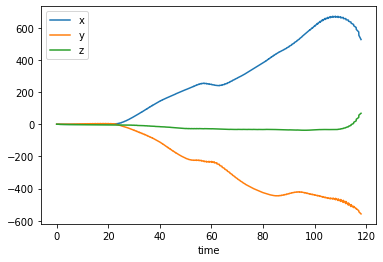

In [312]:
df.plot(x='time', y=['x','y','z'])

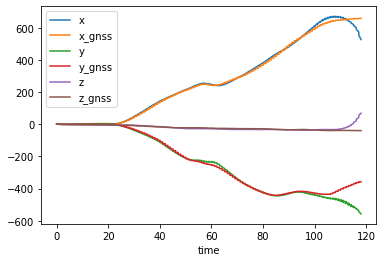

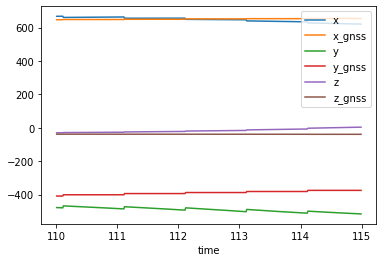

In [322]:
df.plot(x='time', y=['x','x_gnss','y','y_gnss','z','z_gnss'])
df[(df.time > 110 ) & (df.time < 115)].plot(x='time', y=['x','x_gnss','y','y_gnss','z','z_gnss'])

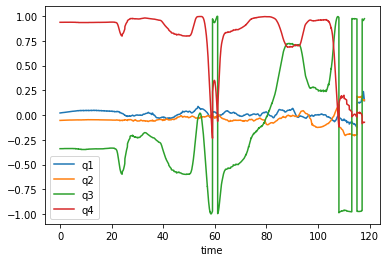

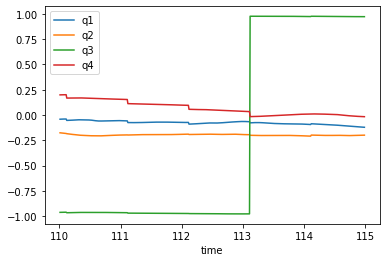

In [314]:
df.plot(x='time', y=[q for q in df.columns if "q" in q])
df[(df.time > 110 ) & (df.time < 115)].plot(x='time', y=[q for q in df.columns if "q" in q])




In [315]:
df[(df.time > 113.5 ) & (df.time < 114.5)]

,gnss_corr,q1,q2,q3,q4,time,vx,vy,vz,x,x_gnss,y,y_gnss,z,z_gnss
0,False,-0.084155,-0.201641,0.975815,-0.006617,113.51,-5.843121,-23.142457,5.348794,638.140678,653.836208,-498.818376,-381.895985,-10.782351,-38.933893
0,False,-0.084394,-0.201674,0.975789,-0.006411,113.52,-5.833904,-23.096905,5.357201,638.082293,653.836208,-499.049572,-381.895985,-10.728821,-38.933893
0,False,-0.084512,-0.201675,0.975780,-0.006160,113.53,-5.821937,-23.046487,5.366692,638.024014,653.836208,-499.280289,-381.895985,-10.675201,-38.933893
0,False,-0.084704,-0.201566,0.975788,-0.005927,113.54,-5.809289,-22.997579,5.380348,637.965858,653.836208,-499.510510,-381.895985,-10.621466,-38.933893
0,False,-0.084848,-0.201494,0.975791,-0.005680,113.55,-5.799967,-22.952445,5.391310,637.907811,653.836208,-499.740260,-381.895985,-10.567608,-38.933893
0,False,-0.084980,-0.201423,0.975796,-0.005360,113.56,-5.788451,-22.901735,5.400770,637.849869,653.836208,-499.969531,-381.895985,-10.513648,-38.933893
0,False,-0.085132,-0.201335,0.975803,-0.005068,113.57,-5.773859,-22.848839,5.417062,637.792058,653.836208,-500.198284,-381.895985,-10.459558,-38.933893
0,False,-0.085287,-0.201365,0.975784,-0.004789,113.58,-5.760179,-22.801584,5.434597,637.734387,653.836208,-500.426536,-381.895985,-10.405300,-38.933893
0,False,-0.085477,-0.201484,0.975745,-0.004487,113.59,-5.746786,-22.752704,5.449392,637.676853,653.836208,-500.654307,-381.895985,-10.350880,-38.933893
0,False,-0.085734,-0.201472,0.975726,-0.004171,113.60,-5.731799,-22.699108,5.465145,637.619460,653.836208,-500.881566,-381.895985,-10.296307,-38.933893


#### Trajectory 2-d

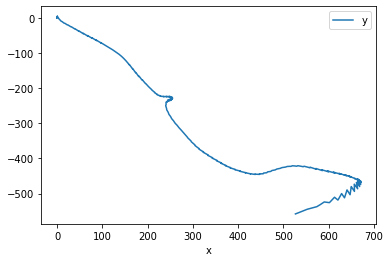

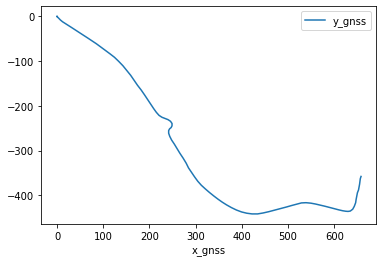

In [316]:
df.plot('x','y')

df.plot('x_gnss','y_gnss')

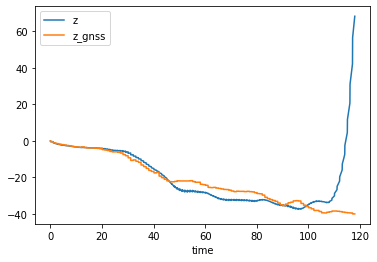

In [317]:
df.plot(x='time',y=['z','z_gnss'])


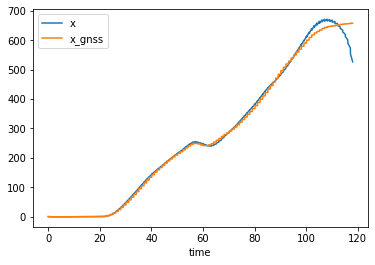

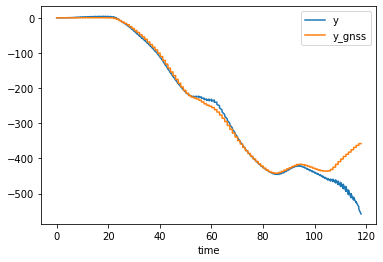

In [318]:

df.plot(x='time',y=['x','x_gnss'])
df.plot(x='time',y=['y','y_gnss'])